In [524]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tabulate import tabulate

In [525]:
# # Load the dataset
data = pd.read_csv("day.csv")

# Drop the fields 
# -instant (an identifier).
# -holiday (low correlation with cnt and skewed results).
# -weekday (low correlation with cnt)
# -atemp or temp (high correlation).
# -windspeed (low correlation with cnt).
# -'casual', 'registered' (information leakage(sum))
columns_to_exclude = ['instant', 'workingday', 'atemp', 'dteday', 'yr', 'casual', 'registered']

X = data.drop(columns=columns_to_exclude + ['cnt'], axis=1)  
names = X.columns
print(names)
y = data['cnt']


Index(['season', 'mnth', 'holiday', 'weekday', 'weathersit', 'temp', 'hum',
       'windspeed'],
      dtype='object')


             instant    season        yr      mnth   holiday   weekday  \
instant     1.000000  0.412224  0.866025  0.496702  0.016145 -0.000016   
season      0.412224  1.000000 -0.001844  0.831440 -0.010537 -0.003080   
yr          0.866025 -0.001844  1.000000 -0.001792  0.007954 -0.005461   
mnth        0.496702  0.831440 -0.001792  1.000000  0.019191  0.009509   
holiday     0.016145 -0.010537  0.007954  0.019191  1.000000 -0.101960   
weekday    -0.000016 -0.003080 -0.005461  0.009509 -0.101960  1.000000   
workingday -0.004337  0.012485 -0.002013 -0.005901 -0.253023  0.035790   
weathersit -0.021477  0.019211 -0.048727  0.043528 -0.034627  0.031087   
temp        0.150580  0.334315  0.047604  0.220205 -0.028556 -0.000170   
atemp       0.152638  0.342876  0.046106  0.227459 -0.032507 -0.007537   
hum         0.016375  0.205445 -0.110651  0.222204 -0.015937 -0.052232   
windspeed  -0.112620 -0.229046 -0.011817 -0.207502  0.006292  0.014282   
casual      0.275255  0.210399  0.2485

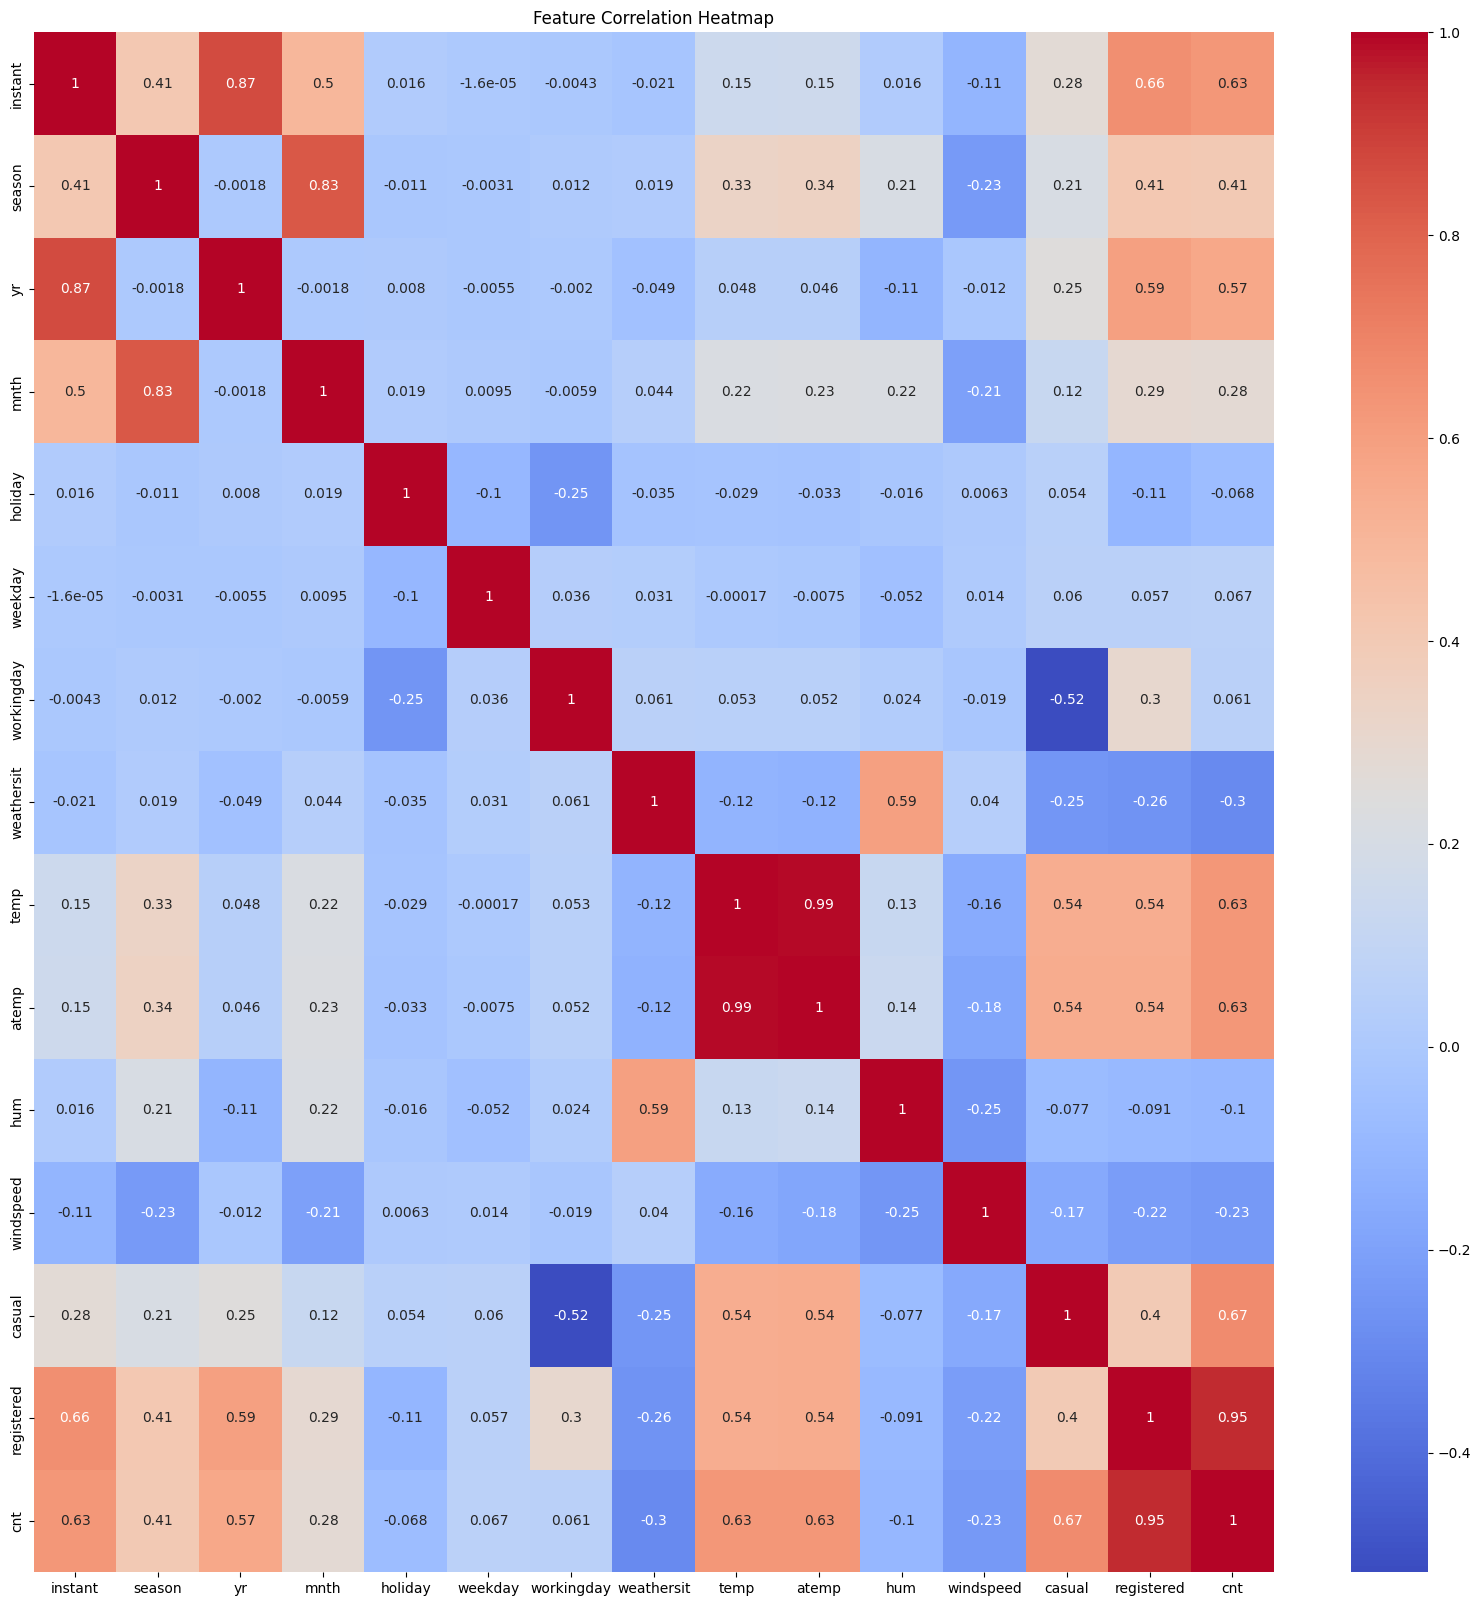

In [526]:
# Correlation
# Select only numeric columns for correlation
# numeric_data = pd.concat([X, y], axis=1).select_dtypes(include=['number'])
numeric_data = data.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Print the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

## BUILT-IN

### Train the model

#### Polynomial Regression

Polynomial regression generalizes linear regression by introducing polynomial terms (e.g., $x^2, x^3$ ) into the model. For a single feature $x$, the polynomial regression equation becomes:

$$
y = \beta_0 + \beta_1 x + \beta_2 x^2 + \cdots + \beta_d x^d + \epsilon
$$

where $d$ is the degree of the polynomial.

Polynomial regression doesn’t directly modify the algorithm. Instead, it transforms the features into polynomial terms, making it possible for a linear model (like `LinearRegression`) to fit non-linear data.

For multiple features ( $x_1, x_2, \dots$ ), polynomial regression generates higher-order interaction terms, such as: $x_1^2, \, x_2^2, \, x_1 x_2$.

#### Linear Regression

Linear regression predicts the target $y$ as a linear combination of the input features $X$:

$$
y = Xw + b
$$

Where:

- $X$ is the matrix of input features.
- $w$ is the vector of weights (coefficients).
- $b$ is the bias term (intercept).

The goal of linear regression is to find the weights $w$ and bias $b$ that minimize the Mean Squared Error (MSE):

$$
L(w, b) = \frac{1}{n} \sum_{i=1}^n \left( y_i - \hat{y}_i \right)^2
$$

This is done using the Normal Equation.

#### Optimization and Normal Equation

To minimize the MSE, we take the derivative of $L(w, b)$ with respect to $w$ and set it to zero.

##### Rewrite the regression equation including the bias:
- Add a column of ones to $X$ to account for $b$.
- Let $\tilde{X}$ be the augmented matrix:

$$
\tilde{X} =
\begin{bmatrix}
1 & X_{11} & X_{12} & \dots \\
1 & X_{21} & X_{22} & \dots \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}
$$

The bias $b$ is treated as part of the weight vector $\tilde{w}$.

##### Express the MSE:
$$
L(w) = \frac{1}{n} \|y - \tilde{X}w\|^2
$$

##### Expand the MSE:
$$
L(w) = \frac{1}{n} \left( y^T y - 2y^T \tilde{X}w + w^T \tilde{X}^T \tilde{X}w \right)
$$

##### Take the derivative with respect to $w$:
$$
\frac{\partial L(w)}{\partial w} = -\frac{2}{n} \tilde{X}^T y + \frac{2}{n} \tilde{X}^T \tilde{X}w
$$

##### Set the derivative to zero:
$$
-\tilde{X}^T y + \tilde{X}^T \tilde{X}w = 0
$$

##### Solve for $w$:
$$
w = \left( \tilde{X}^T \tilde{X} \right)^{-1} \tilde{X}^T y
$$


In [527]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Polynomial Features
poly = PolynomialFeatures(degree=2) 
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

## Local Explanation
Explains why the model made a specific prediction for a single data point (instance) by showing the contribution of each feature or feature interaction.

### Feature Contributions
Each bar represents the magnitude of a feature's impact on the prediction:
  - **Longer bars** indicate stronger influence.
  - **Positive contributions** push the prediction higher, while **negative contributions** (not shown here, but typically in red) lower it.

### Feature Intervals or Values
The feature labels (e.g., `3.00 < season weathersit <= 4.00`) indicate:
  - The range of the feature's value for the instance being explained.
  - The value or condition within that range contributing to the model's decision.

---

### How Does LIME (Local Interpretable Model-agnostic Explanations) Work?

### 1. Perturbations Around the Instance
- LIME generates perturbations (slightly altered versions) of the input data point by modifying its features.
- It then observes how the model's predictions change in response to these perturbations.

If the original instance has:

- **temperature = 20°C**
- **windspeed = 5 km/h**

LIME might create perturbations like:

- **temperature = 21°C, windspeed = 5.5 km/h**
- **temperature = 19°C, windspeed = 4.8 km/h**


### 2. Local Surrogate Model
LIME uses these perturbed samples and their corresponding predictions from the complex model to fit a simpler model (called a surrogate model), such as:

  - Linear regression
  - Decision trees

The surrogate model is trained only on the perturbed samples, focusing on the local region near the instance.

### 3. Feature Importance
- The surrogate model assigns weights to the features, showing their importance in determining the local prediction.

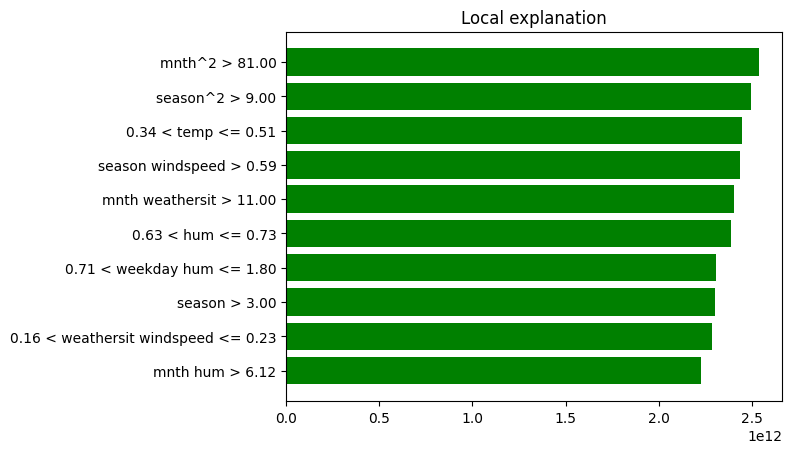

In [528]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize the explainer
explainer = LimeTabularExplainer(
    X_train_poly,  # Use the transformed training data
    mode="regression",
    feature_names=poly.get_feature_names_out(),  # Use feature names from the polynomial features
)

# Select a single instance to explain
instance_to_explain = X_test_poly[0]  # Ensure it's a single row from the transformed test data

# Explain the prediction for this instance
exp = explainer.explain_instance(instance_to_explain, model.predict)

# Visualize the explanation
fig = exp.as_pyplot_figure()
plt.show()


### Observations

#### Top Contributing Features
- **3.00 < season weathersit <= 4.00**:
  - This feature had the largest positive impact on the prediction.
  - The model likely assigns a high weight to this range for this specific prediction.
- **0.67 < weathersit hum <= 1.38**:
  - This feature also had a strong positive contribution, suggesting a significant role of humidity (`hum`) in combination with weather situation (`weathersit`).

#### Feature Interactions
- The plot includes interactions like `temp windspeed` and `mnth^2`, indicating that:
  - Combinations or transformations of features (e.g., squared month values or temperature-wind speed relationships) play a role in the model’s decision.

#### Relative Impact of Features
- Features such as `mnth temp > 5.13` and `mnth^2 > 81.00` also have strong contributions, but they are slightly less impactful than the top two features.
- Features with shorter bars (e.g., `0.13 < windspeed <= 0.18`) have relatively smaller impacts on the model's prediction for this instance.


### Evaluate

In [529]:
# MAE (Mean Absolute Error)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# RMSE (Root Mean Squared Error)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# R² (Coefficient of Determination)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Calculate the range of 'cnt'
cnt_min = y.min()  # Minimum value of cnt
cnt_max = y.max()  # Maximum value of cnt
cnt_range = cnt_max - cnt_min

# Calculate MAE as a percentage of the range
train_mae_percentage = (train_mae / cnt_range) * 100
test_mae_percentage = (test_mae / cnt_range) * 100

# Calculate RMSE as a percentage of the range
train_rmse_percentage = (train_rmse / cnt_range) * 100
test_rmse_percentage = (test_rmse / cnt_range) * 100

print(f"Range of cnt: {cnt_range} (min: {cnt_min}, max: {cnt_max})")

# Print the metrics
print("Evaluation Metrics for Polynomial Regression:")
print(f"Train MAE: {train_mae} ({train_mae_percentage:.2f}% of the range)")
print(f"Test MAE: {test_mae} ({test_mae_percentage:.2f}% of the range)")
print(f"Train RMSE: {train_rmse} ({train_rmse_percentage:.2f}% of the range)")
print(f"Test RMSE: {test_rmse} ({test_rmse_percentage:.2f}% of the range)")
print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")

Range of cnt: 8692 (min: 22, max: 8714)
Evaluation Metrics for Polynomial Regression:
Train MAE: 1024.0732020547946 (11.78% of the range)
Test MAE: 1124.0340136054422 (12.93% of the range)
Train RMSE: 1203.833221946812 (13.85% of the range)
Test RMSE: 1300.228475474743 (14.96% of the range)
Train R²: 0.6046556418118285
Test R²: 0.5783930881839933


### Range Analysis

- **Range of target variable (`cnt`):** 8692 (min: 22, max: 8714)  
- **Significance:** The range provides a context to evaluate the magnitude of the errors (MAE and RMSE). A lower percentage relative to the range indicates better performance.


#### MAE (Mean Absolute Error):

- Indicates the average magnitude of the absolute errors between predicted and actual values.
- The test MAE is slightly higher than the train MAE, but the increase is small (~1.15% of the range). This suggests a mild generalization error, which is acceptable.
- Being ~12-13% of the range is moderately good, but not great. It indicates that predictions are reasonably close but could be improved.


#### RMSE (Root Mean Squared Error):

- Puts a higher penalty on large errors compared to MAE.
- The test RMSE is about 15% higher than the train RMSE, showing a slightly larger deviation on unseen data.
- The values are again moderate, reflecting that there is room for improvement.


#### R² (Coefficient of Determination):

- Train $R^2 = 0.6047$: The model explains ~60% of the variance in training data.
- Test $R^2 = 0.5784$: The model explains ~57.8% of the variance in testing data.
- A small gap between train and test $R^2$ suggests that the model is not overfitting significantly, which is a good sign.


### Cross-Validation
Cross-validation (CV) is a technique used to evaluate the performance of a model by splitting the data into multiple subsets or "folds." The model is trained on a subset of the data (training set) and validated on a different subset (validation set). This process is repeated multiple times (based on the number of folds), and the results are averaged to get a more robust estimate of model performance.

In [530]:
# Perform cross-validation
cv_scores = cross_val_score(model, X_test, y_test, cv=5, scoring='neg_mean_absolute_error')  # 5-fold CV

# Convert scores to positive values (since they're negative for MAE)
cv_scores = -cv_scores

print("Cross-Validation Results:")
print(f"MAE Scores for each fold: {cv_scores}")
print(f"Mean MAE: {cv_scores.mean()}")
print(f"Standard Deviation of MAE: {cv_scores.std()}")

Cross-Validation Results:
MAE Scores for each fold: [1132.25843126 1277.40731514 1198.30439849 1037.07528288 1139.72512755]
Mean MAE: 1156.954111063114
Standard Deviation of MAE: 79.36809001602582


### Residuals

Residuals are the differences between the actual values ($y$) and the predicted values ($\hat{y}$):

$$
\text{Residuals} = y - \hat{y}
$$

**Residual Standard Deviation**: Measures the spread of errors. Smaller standard deviations indicate more consistent predictions.

In [531]:
# Calculate residuals for training and test sets
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Standard deviation of residuals
train_std = np.std(train_residuals)
test_std = np.std(test_residuals)

print(f"Train Residual Standard Deviation: {train_std}")
print(f"Test Residual Standard Deviation: {test_std}")

Train Residual Standard Deviation: 1203.833173841585
Test Residual Standard Deviation: 1282.1952823343072


**Residual Distribution**: Should ideally be symmetric and centered around 0, indicating no systematic bias in predictions (does not systematically overpredict or underpredict).

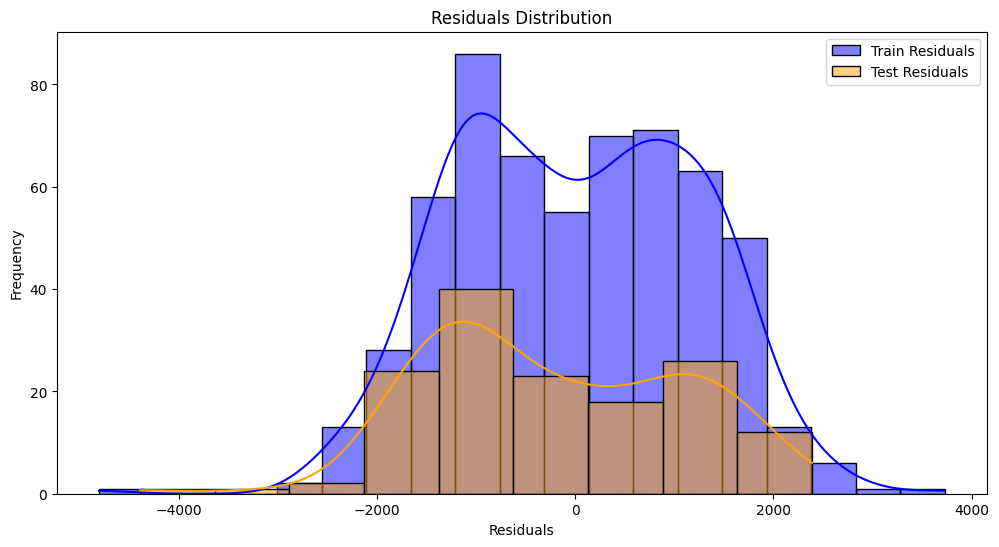

In [532]:
# Plot residual distributions
plt.figure(figsize=(12, 6))

sns.histplot(train_residuals, kde=True, color="blue", label="Train Residuals")
sns.histplot(test_residuals, kde=True, color="orange", label="Test Residuals")

plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Observations

### Symmetry
- Both train and test residuals appear reasonably symmetric around 0.
- This means the model does not consistently overpredict or underpredict.

### Centering Around 0
- Both train and test residuals are centered around 0.
- This indicates that, on average, the model predictions are close to the actual values.

### Spread of Residuals
- **Train Residuals (blue):** Have a tighter spread compared to the test residuals.
- **Test Residuals (orange):** Have a broader spread, as seen from the wider Kernel Density Estimate (KDE).
- This suggests the model performs slightly better on the training data (smaller errors), which is common.

### Range of Residuals
- Most residuals fall within the range of $-2000$ to $2000$ for both training and testing data.
- A few outliers exist in the tails, particularly in the negative direction (e.g., $-4000$), indicating larger errors for some specific predictions.

### Higher Frequency for Train Residuals Near 0
- The peak of the blue curve (train residuals) is higher near 0 compared to the orange curve (test residuals).
- This suggests the model predicts more accurately on the training data, with fewer large residuals.
---

### Confidence interval

**Confidence Intervals**: Indicate the range within which metrics like MAE are expected to fall with 95% confidence. Smaller intervals signify higher confidence in the metrics.

#### 1. Mean
The mean is the central value of the data (e.g., the average of absolute residuals). It represents the best estimate of the metric (e.g., the Mean Absolute Error, MAE).

#### 2. Standard Error (SE)
The standard error (SE) measures how much the sample mean (calculated from your data) is expected to vary from the true population mean.

- A smaller SE indicates more precise estimates.
- Formula for SE:

$$
SE = \frac{\text{standard deviation of the data}}{\sqrt{\text{number of data points}}}
$$

#### 3. Critical Value (t-Score)
To calculate the range of the confidence interval, we use a t-score (from the t-distribution) that depends on:

- The desired confidence level (e.g., 95% confidence corresponds to a t-score of approximately 1.96 for large datasets).
- The sample size (smaller sample sizes require larger t-scores for the same confidence level).

#### 4. Margin of Error
The margin of error is how far above and below the mean the confidence interval extends.

- Formula:

$$
\text{Margin of Error} = SE \times \text{t-score}
$$

#### 5. Confidence Interval
The final confidence interval is:

$$
\text{Confidence Interval} = [\text{mean} - \text{margin}, \text{mean} + \text{margin}]
$$

This gives a range around the mean where we expect the true value to lie with the specified confidence level.


In [533]:
# Function to calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    margin = sem * stats.t.ppf((1 + confidence) / 2., len(data) - 1)
    return mean - margin, mean + margin

# Confidence intervals for MAE
train_mae_ci = confidence_interval(np.abs(train_residuals))
test_mae_ci = confidence_interval(np.abs(test_residuals))

print(f"Train MAE Confidence Interval: {train_mae_ci}")
print(f"Test MAE Confidence Interval: {test_mae_ci}")

Train MAE Confidence Interval: (np.float64(972.596420940401), np.float64(1075.5499831691882))
Test MAE Confidence Interval: (np.float64(1017.1353138181681), np.float64(1230.932713392716))


Summary Table

In [534]:
# Create a summary dataframe specifically for MAE
mae_summary = pd.DataFrame({
    "Metric": ["MAE"],
    "Train Value": [train_mae],
    "Test Value": [test_mae],
    "Train Std Dev": [train_std],
    "Test Std Dev": [test_std],
    "Train CI": [train_mae_ci],
    "Test CI": [test_mae_ci]
})

print(tabulate(mae_summary, headers='keys', tablefmt='pretty'))

+---+--------+--------------------+--------------------+-------------------+--------------------+----------------------------------------------------------------+-----------------------------------------------------------------+
|   | Metric |    Train Value     |     Test Value     |   Train Std Dev   |    Test Std Dev    |                            Train CI                            |                             Test CI                             |
+---+--------+--------------------+--------------------+-------------------+--------------------+----------------------------------------------------------------+-----------------------------------------------------------------+
| 0 |  MAE   | 1024.0732020547946 | 1124.0340136054422 | 1203.833173841585 | 1282.1952823343072 | (np.float64(972.596420940401), np.float64(1075.5499831691882)) | (np.float64(1017.1353138181681), np.float64(1230.932713392716)) |
+---+--------+--------------------+--------------------+-------------------+--------

## SCRATCH

#### Generate Polynomial Features
- Manually create polynomial terms (e.g., $x^2, x^3$) and interaction terms for the input features.
- Example:
  - For a single feature $x$, create new features like $[1, x, x^2, x^3]$.
  - For multiple features $x_1$ and $x_2$, include interaction terms like $x_1 \cdot x_2, x_1^2, x_2^2$.


#### Make Predictions
- Use the fitted coefficients $\beta$ to calculate predictions for the target variable:
  $$
  \hat{y} = X \beta
  $$
  Where:
  - $\hat{y}$ is the vector of predicted values.
  - $X$ is the matrix of polynomial features.
  - $\beta$ is the vector of estimated coefficients.



In [535]:
# Polynomial feature transformation
from itertools import combinations_with_replacement


def polynomial_features(X : np.ndarray, degree: int):
    n_samples, n_features = X.shape
    # Create an array to store polynomial features
    X_poly = np.ones((n_samples, 1))  # Start with the bias (intercept)
    
    # Generate polynomial features
    for d in range(1, degree + 1):
        for combo in combinations_with_replacement(range(n_features), d):
            new_feature = np.prod(X[:, combo], axis=1).reshape(-1, 1)
            X_poly = np.hstack((X_poly, new_feature))
    
    return X_poly

def predict(X, theta):
    return X @ theta

### Gradient Descent 


#### 1. Linear Model Hypothesis:
The hypothesis for linear regression is represented as:

$\hat{y} = X\theta$

In the function, this is computed using:

`X @ theta`

This calculates the predicted values ($\hat{y}$) based on the current parameters ($\theta$).


#### 2. Error Calculation:
The residual error between the predictions ($\hat{y}$) and actual target values ($y$) is:

$\text{Error} = \hat{y} - y = X\theta - y$

In the function, this is implemented as:

`X @ theta - y`


#### 3. Gradient Computation:
To minimize the error, we compute the gradient of the cost function (Mean Squared Error) with respect to $\theta$. The gradient is given by:

$\nabla_\theta J = \frac{2}{n} X^\top (X\theta - y)$

In the function, this is calculated as:

`gradients = (2 / n_samples) * X.T @ (X @ theta - y)`


#### 4. Parameter Update (Gradient Descent):
Using the gradients, the parameters ($\theta$) are updated iteratively to minimize the cost:

$\theta = \theta - \alpha \nabla_\theta J$

In the function, this is done as:

`theta -= learning_rate * gradients`


In [536]:
# Gradient Descent Implementation for Linear Regression
def gradient_descent(X, y, learning_rate=0.01, iterations=1000, lambda_reg=0.01):
    n_samples, n_features = X.shape
    limit = np.sqrt(6 / (n_features + 1))  # For linear regression, +1 is for the bias term
    theta = np.random.uniform(-limit, limit, n_features)
    cost_history = []

    for _ in range(iterations):
        predictions = X @ theta
        gradients = (2 / n_samples) * X.T @ (predictions - y) + 2 * lambda_reg * theta
        theta -= learning_rate * gradients
        cost = (1 / n_samples) * np.sum((predictions - y) ** 2) + lambda_reg * np.sum(theta[1:] ** 2)
        cost_history.append(cost)

    return theta, cost_history


### Train the model

In [537]:
lambda_reg=0.01
cv=5
learning_rate=0.0001
degree=2
iterations=2000

# Ensure NumPy format
X = np.array(X)
y = np.array(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Polynomial transformation
X_train_poly = polynomial_features(X_train, degree)
X_test_poly = polynomial_features(X_test, degree)

model, _ = gradient_descent(X_train_poly, y_train, learning_rate, iterations, lambda_reg)
y_train_pred = X_train_poly @ model
y_test_pred = X_test_poly @ model

### Evaluation Metrics


#### 1. Mean Absolute Error (MAE)
**Formula:**
$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

**Description:**
- Measures the average magnitude of prediction errors, ignoring their direction.
- Provides a simple interpretation: the average absolute difference between actual values (`yᵢ`) and predicted values (`ŷᵢ`).


In [538]:
def mean_absolute_error(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true - y_pred)) / n
    return mae

#### 2. Mean Squared Error (MSE)
**Formula:**
$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

**Description:**
- Represents the average of the squared differences between actual and predicted values.
- Penalizes larger errors more heavily than MAE due to squaring.


In [539]:
def mean_squared_error(y_true, y_pred):
    n = len(y_true)
    mse = sum((y_true - y_pred)**2) / n
    return mse

#### 3. Root Mean Squared Error (RMSE)
**Formula:**
$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

**Description:**
- The square root of MSE, which keeps the units of the error in the same scale as the target variable.
- Widely used as it is sensitive to large errors and provides interpretable results.


In [540]:
def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse**0.5
    return rmse

#### 4. Coefficient of Determination (R²)
**Formula:**
$$
R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$$

**Description:**
- Measures the proportion of variance in the target variable that is explained by the model.
- Ranges from 0 to 1, where higher values indicate a better fit. A value of 1 indicates perfect predictions.

In [541]:
def r2_score(y_true, y_pred):
    y_mean = sum(y_true) / len(y_true)
    ss_total = sum((y_true - y_mean)**2)
    ss_residual = sum((y_true - y_pred)**2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

In [542]:
# MAE (Mean Absolute Error)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# RMSE (Root Mean Squared Error)
train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

# R² (Coefficient of Determination)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Calculate the range of 'cnt'
cnt_min = y.min()  # Minimum value of cnt
cnt_max = y.max()  # Maximum value of cnt
cnt_range = cnt_max - cnt_min

# Calculate MAE as a percentage of the range
train_mae_percentage = (train_mae / cnt_range) * 100
test_mae_percentage = (test_mae / cnt_range) * 100

# Calculate RMSE as a percentage of the range
train_rmse_percentage = (train_rmse / cnt_range) * 100
test_rmse_percentage = (test_rmse / cnt_range) * 100

print(f"Range of cnt: {cnt_range} (min: {cnt_min}, max: {cnt_max})")

# Print the metrics
print("Evaluation Metrics for Polynomial Regression:")
print(f"Train MAE: {train_mae} ({train_mae_percentage:.2f}% of the range)")
print(f"Test MAE: {test_mae} ({test_mae_percentage:.2f}% of the range)")
print(f"Train RMSE: {train_rmse} ({train_rmse_percentage:.2f}% of the range)")
print(f"Test RMSE: {test_rmse} ({test_rmse_percentage:.2f}% of the range)")
print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")

Range of cnt: 8692 (min: 22, max: 8714)
Evaluation Metrics for Polynomial Regression:
Train MAE: 1255.5992498146509 (14.45% of the range)
Test MAE: 1266.404065066875 (14.57% of the range)
Train RMSE: 1507.0363124982823 (17.34% of the range)
Test RMSE: 1513.760127736128 (17.42% of the range)
Train R²: 0.3804300713713006
Test R²: 0.42854439122870414


### Cross-Validation

In [543]:
def cross_validate(X, y, degree, learning_rate=0.001, iterations=1000, cv=5, lambda_reg=0.001):

    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    cv_errors = []

    # Ensure NumPy format
    X = np.array(X)
    y = np.array(y)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Polynomial transformation
        X_train_poly = polynomial_features(X_train, degree)
        X_test_poly = polynomial_features(X_test, degree)

        # Train using regularized gradient descent
        theta, _ = gradient_descent(X_train_poly, y_train, learning_rate, iterations, lambda_reg)

        # Predict and calculate MSE
        y_test_pred = X_test_poly @ theta
        mse = mean_absolute_error(y_test, y_test_pred)
        cv_errors.append(mse)

    print(cv_errors)
    return np.mean(cv_errors), np.std(cv_errors)

In [544]:
# Cross-validate
mean_error, std_error = cross_validate(X, y, degree=degree, learning_rate=learning_rate, iterations=iterations, cv=cv, lambda_reg=lambda_reg)
print(f"Mean Error: {mean_error}, Std Dev: {std_error}")


[np.float64(1266.463233054714), np.float64(1335.7668284362744), np.float64(1152.2493575755725), np.float64(1249.0792377179255), np.float64(1318.403660284078)]
Mean Error: 1264.3924634137127, Std Dev: 64.53893169999601


### Residuals

In [545]:
# Calculate residuals for training and test sets
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Standard deviation of residuals
train_std = np.std(train_residuals)
test_std = np.std(test_residuals)

print(f"Train Residual Standard Deviation: {train_std}")
print(f"Test Residual Standard Deviation: {test_std}")

Train Residual Standard Deviation: 1493.048531146738
Test Residual Standard Deviation: 1512.8777707205084


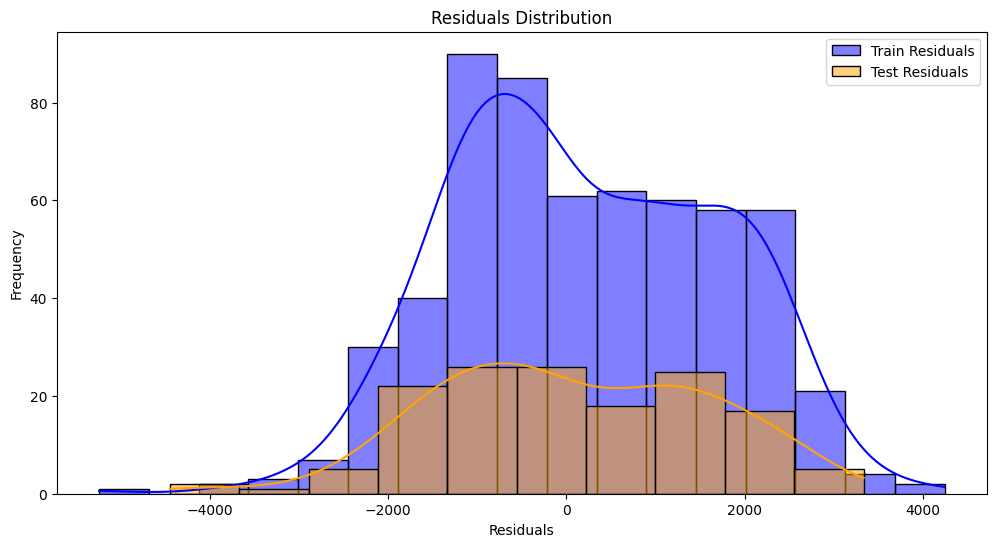

In [546]:
# Plot residual distributions
plt.figure(figsize=(12, 6))

sns.histplot(train_residuals, kde=True, color="blue", label="Train Residuals")
sns.histplot(test_residuals, kde=True, color="orange", label="Test Residuals")

plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Confidence Interval

In [547]:
# Function to calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    margin = sem * stats.t.ppf((1 + confidence) / 2., len(data) - 1)
    return mean - margin, mean + margin

# Confidence intervals for MAE
train_mae_ci = confidence_interval(np.abs(train_residuals))
test_mae_ci = confidence_interval(np.abs(test_residuals))

print(f"Train MAE Confidence Interval: {train_mae_ci}")
print(f"Test MAE Confidence Interval: {test_mae_ci}")

Train MAE Confidence Interval: (np.float64(1187.8050089591077), np.float64(1323.3934906701936))
Test MAE Confidence Interval: (np.float64(1130.7655652633998), np.float64(1402.04256487035))


In [548]:
# Create a summary dataframe specifically for MAE
mae_summary = pd.DataFrame({
    "Metric": ["MAE"],
    "Train Value": [train_mae],
    "Test Value": [test_mae],
    "Train Std Dev": [train_std],
    "Test Std Dev": [test_std],
    "Train CI": [train_mae_ci],
    "Test CI": [test_mae_ci]
})

print(tabulate(mae_summary, headers='keys', tablefmt='pretty'))

+---+--------+--------------------+-------------------+-------------------+--------------------+------------------------------------------------------------------+----------------------------------------------------------------+
|   | Metric |    Train Value     |    Test Value     |   Train Std Dev   |    Test Std Dev    |                             Train CI                             |                            Test CI                             |
+---+--------+--------------------+-------------------+-------------------+--------------------+------------------------------------------------------------------+----------------------------------------------------------------+
| 0 |  MAE   | 1255.5992498146509 | 1266.404065066875 | 1493.048531146738 | 1512.8777707205084 | (np.float64(1187.8050089591077), np.float64(1323.3934906701936)) | (np.float64(1130.7655652633998), np.float64(1402.04256487035)) |
+---+--------+--------------------+-------------------+-------------------+---------